In [1]:
#!pip install --upgrade matplotlib
#!pip install plotly-geo
#!pip install geopandas==0.8.1
#!pip install pyshp==1.2.10
#!pip install shapely==1.6.3

In [2]:
# Basic libraries
import pandas as pd 
import numpy as np
import re

# Visualisation libraries
import matplotlib.pyplot as plt 
import seaborn as sns


# Modelling libraries
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Set styles and display options
sns.set_palette('mako')
pd.options.display.precision = 4

In [3]:
# Functions
def farenheit_to_celsius(farenheit):
  return ((farenheit - 32) * (5/9))

def m_to_km(m):
  return (m*1.609344)

def in_to_mm(i):
  return (i*25.4)

# Function to retrieve performance metrics
def scores(name, y_test, y_pred):
        list = [name,
                precision_score(y_test, y_pred, average='weighted'),
                recall_score(y_test, y_pred, average='weighted'),
                f1_score(y_test, y_pred, average='weighted'),
                accuracy_score(y_test, y_pred)]
        return list

In [4]:
# Load data
# ny = pd.read_csv('ny_accidents.csv')

In [5]:
# Import data for Google Collab. Remove before submission
url = 'https://raw.githubusercontent.com/aqualytics/INFT6201-Assignment3/main/ny_accidents.csv?token=GHSAT0AAAAAABZNNFLGDHXVZMJZZRLCVUMQYZXUG3Q'
df = pd.read_csv(url)


In [6]:
# Drop columns that won't be used in the analysis
try: # remove exception handling before submission
  cols = ['Unnamed: 0','Number', 'Airport_Code', 'Timezone', 'Country', 'State', 'Civil_Twilight','Nautical_Twilight','Astronomical_Twilight','Turning_Loop']
  df.drop(cols, axis=1, inplace=True)
except:
  pass

# Drop duplicates
df.drop_duplicates()

# Drop rows with na values
df.dropna(inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36779 entries, 0 to 39536
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 36779 non-null  object 
 1   Severity           36779 non-null  int64  
 2   Start_Time         36779 non-null  object 
 3   End_Time           36779 non-null  object 
 4   Start_Lat          36779 non-null  float64
 5   Start_Lng          36779 non-null  float64
 6   End_Lat            36779 non-null  float64
 7   End_Lng            36779 non-null  float64
 8   Distance.mi.       36779 non-null  float64
 9   Description        36779 non-null  object 
 10  Street             36779 non-null  object 
 11  Side               36779 non-null  object 
 12  City               36779 non-null  object 
 13  County             36779 non-null  object 
 14  Zipcode            36779 non-null  object 
 15  Weather_Timestamp  36779 non-null  object 
 16  Temperature.F.     367

In [7]:
# Pre-process of data
# Rename columns 
df.rename(columns = {'Distance.mi.':'Distance',
                     'Wind_Speed.mph.':'Wind_Speed',
                     'Temperature.F.':'Temperature',
                     'Wind_Chill.F.':'Wind_Chill',
                     'Humidity...':'Humidity',
                     'Pressure.in.':'Pressure',
                     'Visibility.mi.':'Visibility',
                     'Precipitation.in.':'Precipitation'}, inplace=True)

# Variable groups as lists
weather = ['Weather_Timestamp', 'Temperature', 'Wind_Chill', 'Humidity', 'Pressure','Visibility','Wind_Direction','Wind_Speed','Precipitation','Weather_Condition']
poi = ['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']

# Convert dates & times to datetime type
cols = ['Start_Time','End_Time','Weather_Timestamp']
df[cols] = df[cols].apply(pd.to_datetime, errors='coerce')

# Convert imperial units to metric
df[['Temperature', 'Wind_Chill']] = df[['Temperature', 'Wind_Chill']].apply(farenheit_to_celsius) # farenheit to celsius
df[['Visibility', 'Wind_Speed']] = df[['Visibility', 'Wind_Speed']].apply(m_to_km) # miles to kilometres
df['Precipitation'] = df['Precipitation'].apply(farenheit_to_celsius) # inches to mm

# Add severity_cat column
conditions  = [ df['Severity'] == 1, df['Severity'] == 2, df['Severity'] == 3, df['Severity'] == 4 ]
choices     = [ 'Short', 'Medium-Short','Medium-Long', 'Long']
df['severitycat'] = np.select(conditions, choices, default=np.nan)

# Add incident_road_type column
keywords = ['Ave', 'St', 'Rd', 'Blvd', 'Dr', 'Avenue', 'Parkway', 'Pkwy']
df['road_type'] = 1 #where 1 = high speed road
df.loc[df['Street'].str.contains('|'.join(keywords), case = False) == True, 'road_type'] = 0 #where 0 = local road

# Add numerical_road_type column
keywords = ['Ave', 'St', 'Rd', 'Blvd', 'Dr', 'Avenue', 'Parkway', 'Pkwy']
df['num_road_type'] = 1
df.loc[df['Street'].str.contains('|'.join(keywords), case = False) == True, 'num_road_type'] = 0

# Add weather_cat column to consolidate weather conditions
conditions = [df['Weather_Condition'].str.contains('Clear|Fair', case=False) == True,
              df['Weather_Condition'].str.contains('Cloud|Overcast', case=False) == True,
              df['Weather_Condition'].str.contains('Rain|Storm', case=False) == True,
              df['Weather_Condition'].str.contains('Heavy Rain|Rain Shower|Heavy T-Storm|Heavy Thunderstorms', case=False) == True,
              df['Weather_Condition'].str.contains('Snow|Sleet|Ice', case=False) == True,
              df['Weather_Condition'].str.contains('Heavy Snow|Heavy Sleet|Heavy Ice Pellets|Snow Showers|Squalls', flags=re.IGNORECASE, regex=True) == True,
              df['Weather_Condition'].str.contains('Fog', case=False) == True]
choices = ['Clear', 'Cloud', 'Rain', 'Heavy_rain', 'Snow', 'Heavy_Snow','Fog']
df['Weather_Condition'] = np.select(conditions, choices, default='Other') # Assign null value as clear

# Clean wind direction
df['Wind_Direction'].replace({'North':'N','West':'W','East':'E','Variable':'VAR','South':'S'}, inplace=True)


# Add season category
df['month'] = df['Start_Time'].dt.month
conditions = (df.month < 3, df.month < 5, df.month < 8, df.month <12, df.month == 12)
choices = ['winter', 'spring','summer', 'fall', 'winter']
df['season'] = np.select(conditions, choices, default=np.nan)
df.drop('month', axis=1, inplace=True)

# Add weekday
df['weekday'] = df['Start_Time'].dt.dayofweek

# Add month
df['month'] = df['Start_Time'].dt.month

# Add year
df['year'] = df['Start_Time'].dt.year

# Add incident duration
df['duration'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds().div(60).astype(int)

In [8]:
# Summarise weather data
num_weather = ['Temperature', 'Wind_Chill', 'Humidity', 'Pressure','Visibility','Wind_Speed','Precipitation'] # weather columns containing numerical variables
df_weather_stats = df[num_weather].describe().T
df_weather_stats = pd.concat([df_weather_stats, df[num_weather].skew()], axis=1).rename(columns={0:'Skewness'})
df_weather_stats = pd.concat([df_weather_stats, df[num_weather].kurt()], axis=1).rename(columns={0:'Kurtosis'})
display(df_weather_stats)

# Boxplot each variable

,count,mean,std,min,25%,50%,75%,max,Skewness,Kurtosis
Temperature,36779.0,11.4065,9.1831,-24.4444,4.4444,11.1111,18.3333,35.5556,0.0293,-0.5393
Wind_Chill,36779.0,9.9979,10.7082,-34.6667,1.6667,11.1111,18.3333,35.5556,-0.1464,-0.6776
Humidity,36779.0,66.1843,20.5300,13.0000,50.0000,68.0000,84.0000,100.0000,-0.2221,-0.9989
Pressure,36779.0,29.6950,0.3921,27.5500,29.4500,29.7200,29.9700,30.7100,-0.7262,1.5056
Visibility,36779.0,14.5244,4.3196,0.0000,16.0934,16.0934,16.0934,32.1869,-1.8470,3.6659
Wind_Speed,36779.0,14.6017,9.4350,0.0000,8.0467,12.8748,20.9215,64.3738,0.6788,0.7363
Precipitation,36779.0,-17.7748,0.0153,-17.7778,-17.7778,-17.7778,-17.7778,-17.3167,10.2372,149.7634


## Explore the dataset

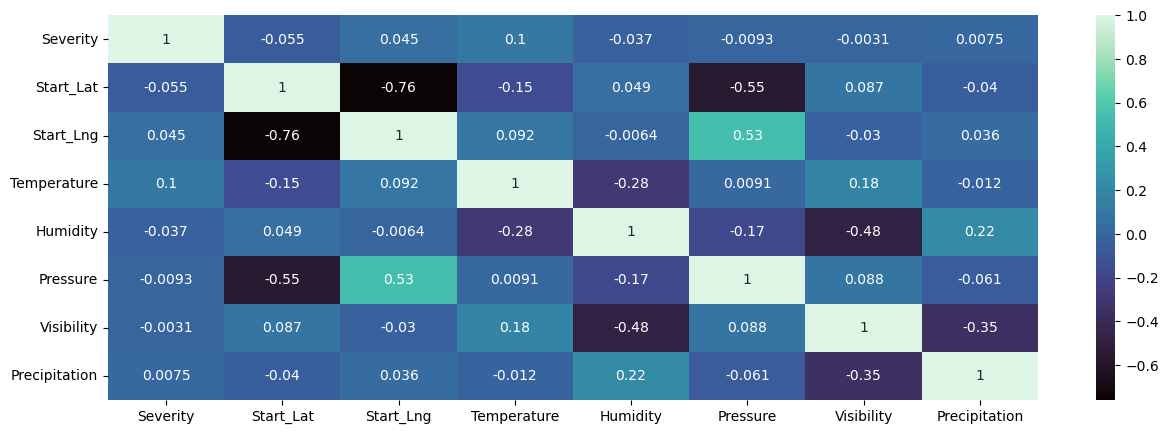

In [9]:
# Find correlations for weather features
plt.figure(figsize=(15,5))
sns.heatmap(df[['Severity','Start_Lat','Start_Lng','Temperature', 'Humidity', 'Pressure', 'Visibility','Precipitation','Weather_Condition']].corr(), cmap='mako', annot=True)
plt.show()

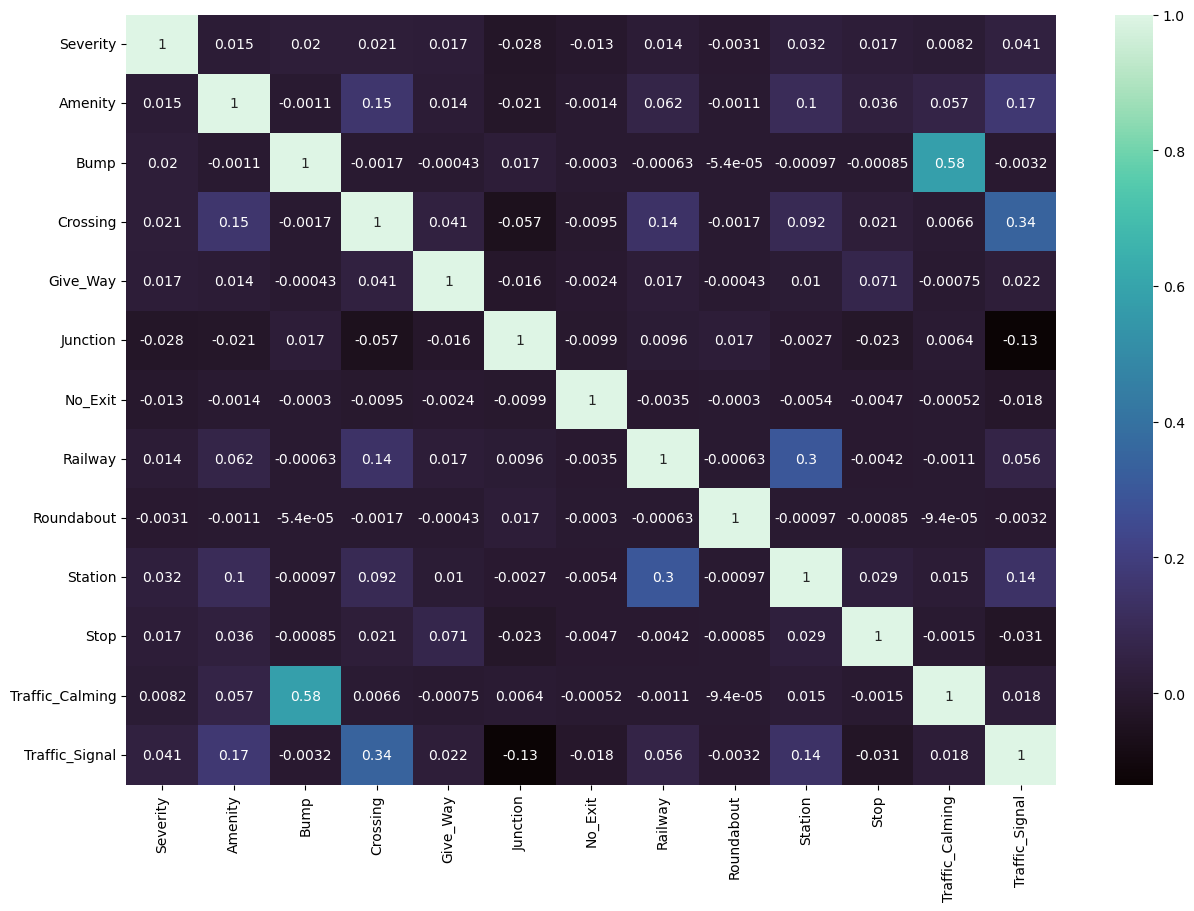

In [10]:
# Find correlations for poi features 
plt.figure(figsize=(15,10))
sns.heatmap(df[['Severity','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']].corr(), cmap='mako', annot=True)
plt.show()

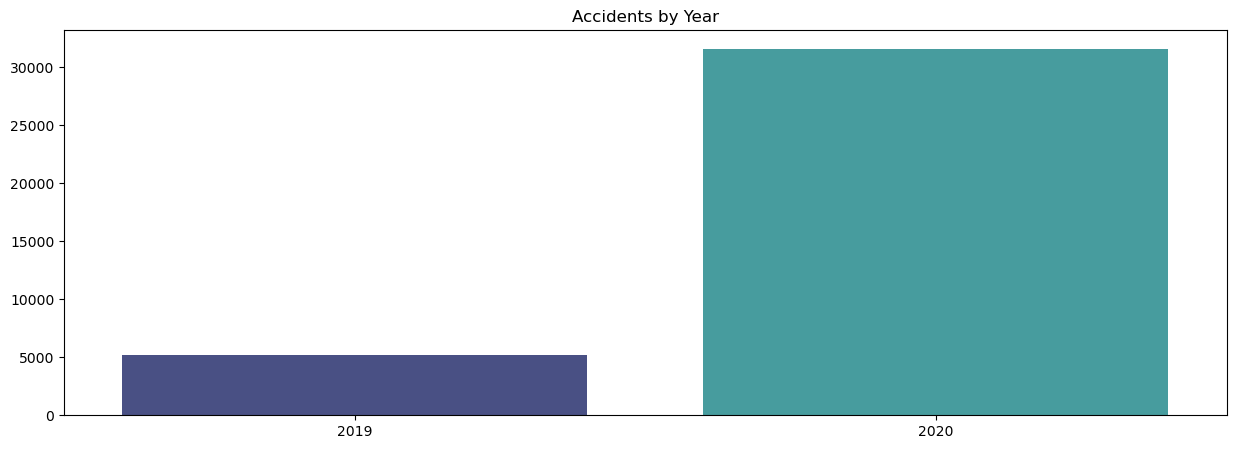

In [11]:
# Accident Severity Counts by Year
plt.figure(figsize=(15,5))
ax = sns.countplot(x='year', data=df, palette = 'mako')
ax.set(title='Accidents by Year', xlabel="", ylabel="")
plt.show()

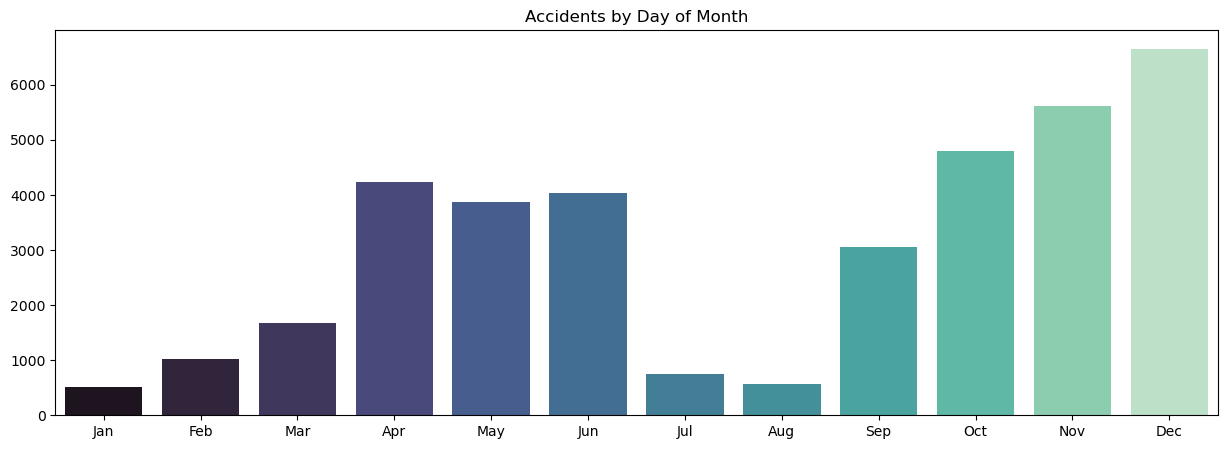

In [12]:
# Accident Severity Counts by Month
plt.figure(figsize=(15,5))
ax = sns.countplot(x='month', data=df, palette = 'mako')
ax.set(title='Accidents by Day of Month', xlabel="", ylabel="")
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.show()

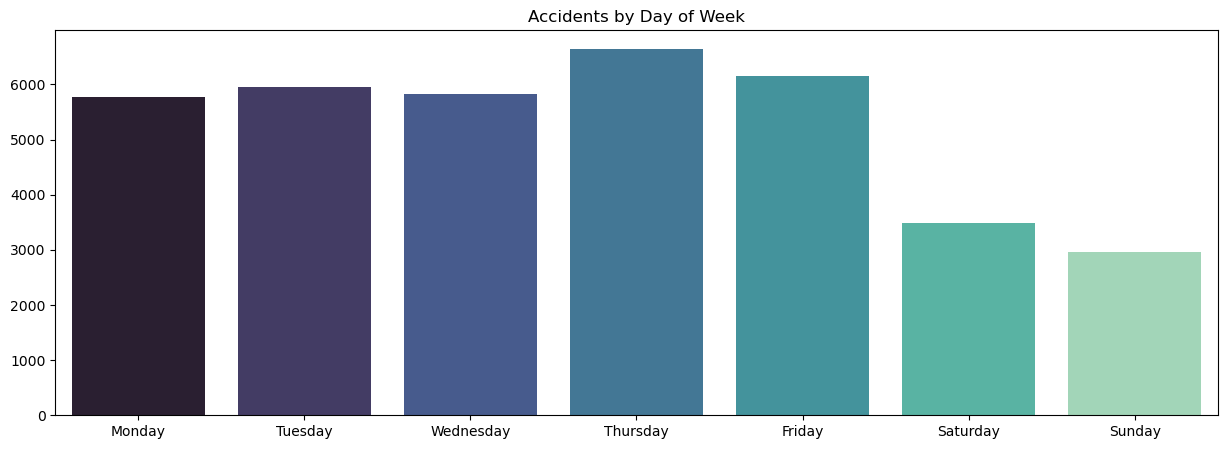

In [13]:
# Accident Severity Counts by Day of Week
plt.figure(figsize=(15,5))
ax = sns.countplot(x='weekday', data=df, palette = 'mako')
ax.set(title='Accidents by Day of Week', xlabel = "", ylabel="")
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday','Saturday','Sunday'])
plt.show()

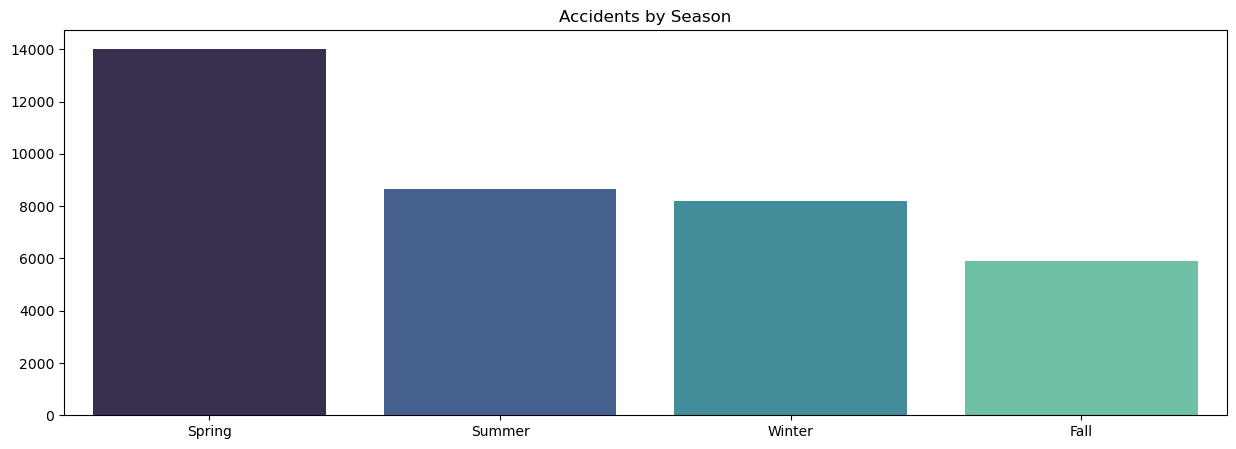

In [14]:
# Accident Severity Counts by Season
plt.figure(figsize=(15,5))
ax = sns.countplot(x='season', data=df, order = {'spring','summer','fall','winter'}, palette = 'mako')
ax.set(title='Accidents by Season', xlabel = "", ylabel="")
ax.set_xticklabels(['Spring','Summer', 'Winter', 'Fall'])
plt.show()

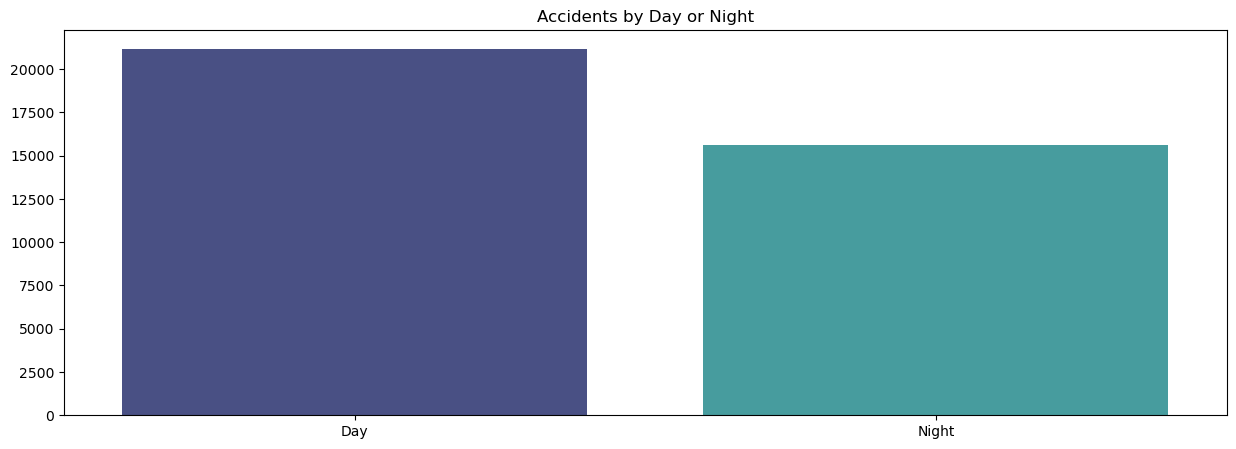

In [15]:
# Accident Severity Counts by Day/Night
plt.figure(figsize=(15,5))
ax = sns.countplot(x='Sunrise_Sunset', data=df, order={'Day', 'Night'}, palette = 'mako')
ax.set(title='Accidents by Day or Night', xlabel="", ylabel="")

# show plot
plt.show()

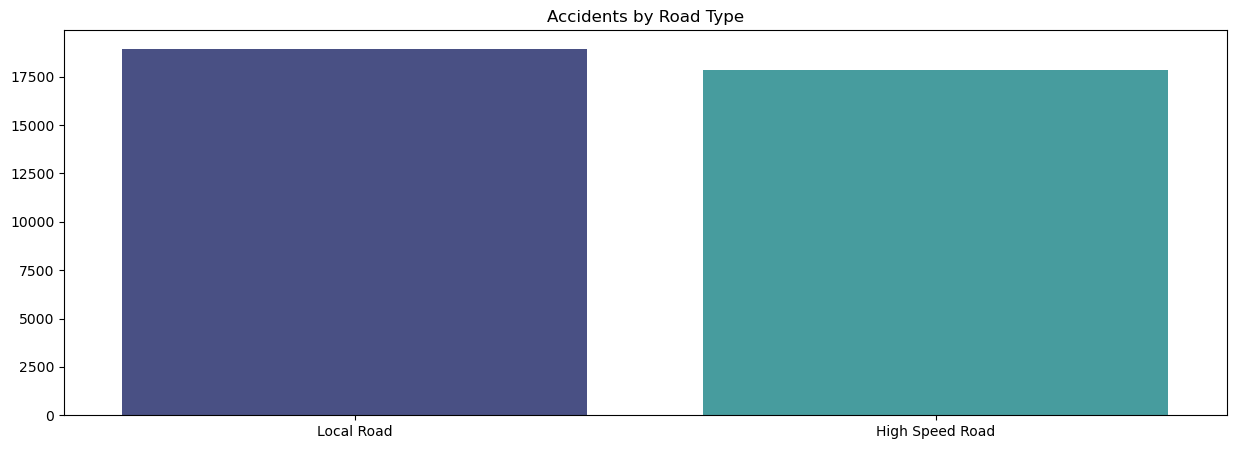

In [16]:
# Accident Severity Counts by Road Type
# define the figure size
plt.figure(figsize=(15,5))

# create count plot for severity for each year
ax = sns.countplot(x='road_type', data=df, palette = 'mako')

# set the ticks, labels and title
ax.set(title='Accidents by Road Type', xlabel="", ylabel="")
ax.set_xticklabels(['Local Road','High Speed Road'])

# show plot
plt.show()

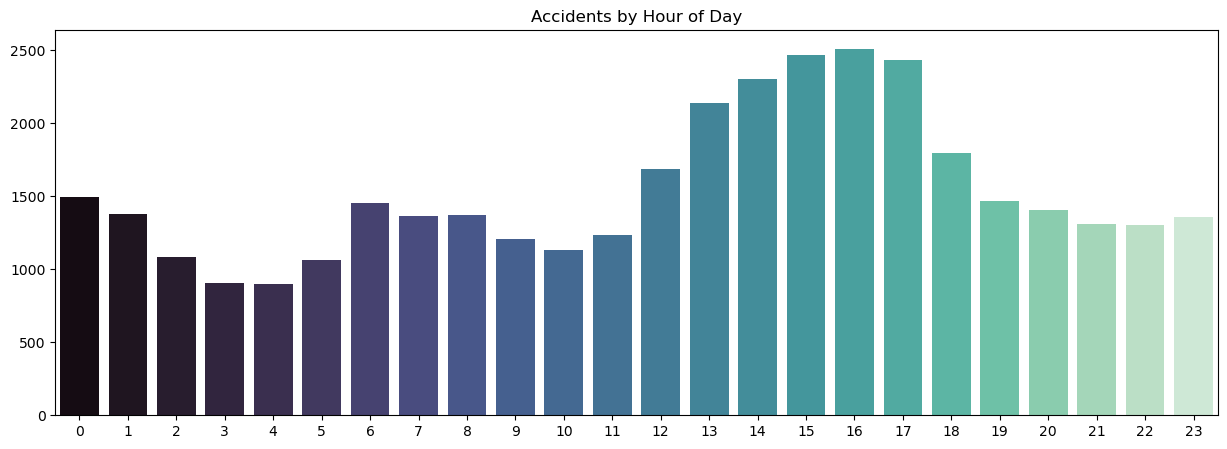

In [17]:
# Number of accidents per hour
plt.figure(figsize=(15,5))
ax = sns.countplot(x=df['Start_Time'].dt.hour, data=df, palette = 'mako')
ax.set(title='Accidents by Hour of Day', xlabel="", ylabel="")
plt.show()

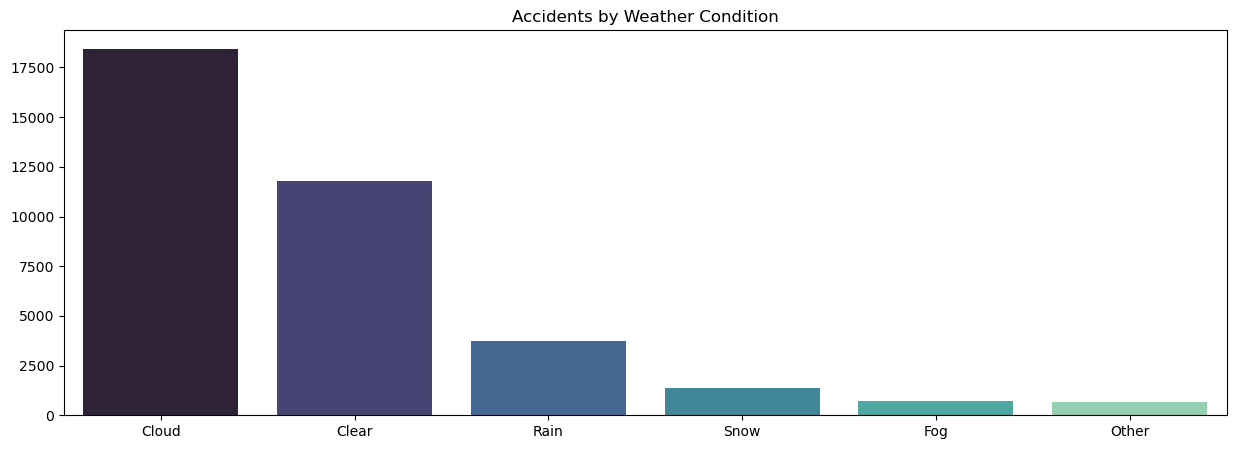

In [18]:
# Accident Severity Counts by Weather Conditions
plt.figure(figsize=(15,5))
plot_order = df.groupby('Weather_Condition')['Weather_Condition'].count().sort_values(ascending=False).index.values
ax = sns.countplot(x='Weather_Condition', data=df, order=plot_order, palette='mako')
ax.set(title='Accidents by Weather Condition', xlabel="", ylabel="")
plt.show()

In [20]:
# Classification Models to predict Severity

# Prepare training and test data
exclude = ['ID', 'Start_Time', 'End_Time','Description', 'Street', 'Side','City','County','Zipcode','Weather_Timestamp', 'Wind_Direction','Severity', 'Weather_Condition', 'Sunrise_Sunset','road_type','severitycat','season','duration']
df_feat = df.copy().drop(columns = exclude)
df_target = df.Severity.copy()

# Split training and test data
X_train, X_test, y_train, y_test = train_test_split(df_feat, df_target, test_size = 0.5, random_state=1)

# Balance training dataset
from imblearn.combine import SMOTETomek
smo_tek = SMOTETomek(random_state=1)
X_train, y_train = smo_tek.fit_resample(X_train, y_train)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

# Create df to store model performance 
results = pd.DataFrame(columns = ['Model','Precision', 'Recall','F1-Score','Accuracy'])

In [21]:
# Classification of severity
# Supervised Learning Algorithms
# Logistic regression

parameters = {
    "solver":['newton-cg'],
    "penalty":['l2'],
    "C":[0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Find the best value of n parameters for accuracy
grid = GridSearchCV(LogisticRegression(), param_grid = parameters, cv=5, scoring='f1_weighted')
grid.fit(X_train, y_train)

# Return parameters of model with highest accuracy
optimal_model = grid.best_estimator_
print('Best parameters are: ')
print( grid.best_params_)

grid_predictions = grid.predict(X_test) # Perform prediction on test data
results.loc[len(results)] = scores('Logistic Regression', y_test, grid_predictions) # Store metrics to results df

Best parameters are: 
{'C': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}


In [22]:
# K-Nearest Neghbours
parameters = {'n_neighbors': np.arange(1, 20)}

# Find the best value of n parameters for accuracy
grid = RandomizedSearchCV(KNeighborsClassifier(), parameters, cv = 2, random_state=1, scoring='f1_weighted')
grid.fit(X_train, y_train)

# Return parameters of model with highest accuracy
optimal_model = grid.best_estimator_
print('Best parameters are: ')
print( grid.best_params_)

grid_predictions = grid.predict(X_test) # Perform prediction on test data
results.loc[len(results)] = scores('KNN', y_test, grid_predictions) # Store metrics to results df

Best parameters are: 
{'n_neighbors': 2}


In [23]:
# SVM
# Defining parameter range for grid search
parameters ={
    "C":[0.1,1],
    "kernel":['linear'],
    "gamma":['scale', 'auto']
}

# Find the best SVM model parameters for accuracy
grid = GridSearchCV(SVC(), param_grid = parameters, cv = 2, verbose=2, scoring='f1_weighted')
grid.fit(X_train, y_train)

# Return parameters of model with highest accuracy
optimal_model = grid.best_estimator_
print('Best parameters are: ')
print( grid.best_params_)

grid_predictions = grid.predict(X_test) # Perform prediction on test data
results.loc[len(results)] = scores('SVM', y_test, grid_predictions) # Store metrics to results df

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  38.9s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  42.9s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=  39.0s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=  43.4s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=  59.6s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time= 1.2min
[CV] END .....................C=1, gamma=auto, kernel=linear; total time= 1.0min
[CV] END .....................C=1, gamma=auto, kernel=linear; total time= 1.2min
Best parameters are: 
{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


In [24]:
# Unsupervised Learning Algorithms
# Random Forest
mod = RandomForestClassifier(random_state=1).fit(X_train, y_train) # train model
predicted_class = mod.predict(X_test) # perform prediction

results.loc[len(results)] = scores('Random Forest', y_test, predicted_class) # store performance metrics to results df

In [25]:
# AdaBoost
# mod = AdaBoostClassifier(random_state=1).fit(X_train, y_train) # train model
# predicted_class = mod.predict(X_test) # perform prediction

# results.loc[len(results)] = scores('AdaBoost', y_test, predicted_class) # store performance metrics to results df

In [26]:
# GradientBoosting
mod = GradientBoostingClassifier(random_state=1).fit(X_train, y_train) # train model
predicted_class = mod.predict(X_test) # perform prediction

results.loc[len(results)] = scores('Gradient Boosting', y_test, predicted_class) # store performance metrics to results df

In [27]:
# Output results of models
display(results.round(4).style.hide(axis = 'index'))

Model,Precision,Recall,F1-Score,Accuracy
Logistic Regression,0.794900,0.629300,0.684400,0.629300
KNN,0.818200,0.802400,0.808700,0.802400
SVM,0.816700,0.627700,0.686500,0.627700
Random Forest,0.860100,0.840800,0.848100,0.840800
AdaBoost,0.747300,0.392600,0.453800,0.392600
GradientBoosting,0.822700,0.714200,0.748300,0.714200
